In [3]:
#%%
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../..")
sys.path.append("../bin_sup_con_learning/binary_learning/")

import pytorch_lightning as pl
import torch
import numpy as np

pl.seed_everything(100, workers=True)

Seed set to 100


100

In [4]:
from metrics import calculate_sample_alignment_distance, calculate_sample_alignment_accuracy, calculate_class_alignment_distance, calculate_class_alignment_consistency, calculate_gaussian_potential_uniformity, calculate_probabilistic_entropy_uniformity
from sklearn.metrics.pairwise import pairwise_distances


def gen_all_metrics(embeddings, labels):
    n_samples = embeddings[0].shape[0]
    all_embeddings = np.concatenate(embeddings, axis=0)
    all_labels = np.concatenate(labels, axis=0)

    indices_0 = np.where(all_labels == 0)[0]
    indices_1 = np.where(all_labels == 1)[0]

    # Simulate similarity matrix
    sim = pairwise_distances(
        all_embeddings, metric="euclidean") + np.eye(all_embeddings.shape[0])

    sad_0, sad_1 = calculate_sample_alignment_distance(
        sim, n_samples, labels[0])

    saa_0, saa_1 = calculate_sample_alignment_accuracy(
        sim, n_samples, labels[0],all_labels)

    cad_0, cad_1 = calculate_class_alignment_distance(
        sim, all_embeddings, all_labels)

    cac_0, cac_1 = calculate_class_alignment_consistency(
        sim, all_embeddings, all_labels)

    # Gaussian Potential Uniformity
    gu_0, gu_1 = calculate_gaussian_potential_uniformity(
        all_embeddings, all_labels)

    # Probabilistic Entropy Uniformity
    uniformity_entropies_cls0, uniformity_entropies_cls1 = calculate_probabilistic_entropy_uniformity(
        all_embeddings, all_labels)

    mean_entropy_cls0 = np.mean(uniformity_entropies_cls0)
    std_entropy_cls0 = np.std(uniformity_entropies_cls0)

    mean_entropy_cls1 = np.mean(uniformity_entropies_cls1)
    std_entropy_cls1 = np.std(uniformity_entropies_cls1)

    print(f"{sad_0.mean():.3f} & {sad_1.mean():.3f} &", f"{(saa_0 / indices_0.shape[0]):.1f} & {(saa_1 / indices_1.shape[0]):.1f}",
          f" & {np.array(cad_0).mean():.3f} & {np.array(cad_1).mean():.3f} & ",   f"{cac_0.mean():.1f} & {cac_1.mean():.1f}", f" & {gu_0:.3f} & {gu_1:.3f} &",
          f"{mean_entropy_cls0:.2f} $\pm$ {std_entropy_cls0:.2f} & {mean_entropy_cls1:.2f} $\pm$  {std_entropy_cls1:.2f}")

    # Compile results
    results = {
        "sample_alignment_distance_cls0": sad_0,
        "sample_alignment_distance_cls1": sad_1,
        "sample_alignment_accuracy_cls0": saa_0,
        "sample_alignment_accuracy_cls1": saa_1,
        "class_alignment_distance_cls0": cad_0,
        "class_alignment_distance_cls1": cad_1,
        "class_alignment_consistency_cls0": cac_0,
        "class_alignment_consistency_cls1": cac_1,
        "gaussian_potential_uniformity_cls0": gu_0,
        "gaussian_potential_uniformity_cls1": gu_1,
        "uniformity_entropies_cls0": uniformity_entropies_cls0,
        "uniformity_entropies_cls1": uniformity_entropies_cls1,

    }

    return results

In [5]:
res = {}

In [6]:

class_name = "mammals"

#models =  [ "1-99","5-95","50-50",]#"fix_unsup1-99","fix_unsup5-95","fix_unsup50-50"]
models = []
models.extend(["sup1-99","sup50-50","sup5-95",])#"fix2_1-99","fix2_5-95","fix3_1-99","fix3_5-95","fix3_50-50"])
#models = ["sup50-50", "fix3_50-50", "50-50", "fix_unsup50-50",]# "sup5-95", "fix2_5-95", "fix3_5-95", "5-95", "fix_unsup5-95"]
#models = ["sup5-95", "fix2_5-95", "fix3_5-95", "5-95", "fix_unsup5-95"]



In [7]:
import pickle
import os

re = False

if not os.path.exists(f'/vol/miltank/users/mildenbd/Projects/icml/embeddings/{class_name}/results_5_last_val.pkl'):
    for model in models:

        with open(f'/vol/miltank/users/mildenbd/Projects/icml/embeddings/{class_name}/embeddings_5_last_val__{model}.pkl', 'rb') as file:
            embeddings = pickle.load(file)
        with open(f'/vol/miltank/users/mildenbd/Projects/icml/embeddings/{class_name}/labels_5_last_val__{model}.pkl', 'rb') as file:
            labels = pickle.load(file)

        print(f'{class_name}_{model}')
        res[f'{class_name}_{model}'] = gen_all_metrics(embeddings, labels)
        
        with open(f'/vol/miltank/users/mildenbd/Projects/icml/embeddings/{class_name}/results_5_last_val.pkl', 'wb') as file:
            pickle.dump(res, file)
else:
    res = pickle.load(open(f'/vol/miltank/users/mildenbd/Projects/icml/embeddings/{class_name}/results_5_last_val.pkl', 'rb'))

In [8]:
def prepare_data_point_merged(metric, has_fix2=False):
    """
    Prepares a DataFrame by merging Class 0 and Class 1 data for point plotting.

    Parameters:
    - metric (str): The metric to prepare data for (e.g., 'sample_alignment_distance').
    - has_fix2 (bool, optional): Indicates whether to include 'fix2' data. Defaults to False.

    Returns:
    - pd.DataFrame: Prepared data for point plotting with merged classes.
    """
    import numpy as np
    import pandas as pd

    # Initialize lists to store merged data and corresponding imbalance labels
    merged_data = []
    imbalance_labels = []

    # Define data subsets and corresponding imbalance levels
    if has_fix2:
        subsets = ['fix2_1-99', 'fix2_5-95']
        imbalance_levels = ['1%', '5%']
    else:
        subsets = ['fix3_1-99', 'fix3_5-95', 'fix3_50-50']
        imbalance_levels = ['1%', '5%', '50%']

    # Iterate over each subset and merge Class 0 and Class 1 data
    for subset, imbalance in zip(subsets, imbalance_levels):
        # Construct keys for Class 0 and Class 1
        cls0_key = f'{class_name}_{subset}'
        cls1_key = f'{class_name}_{subset}'

        # Safely retrieve data; handle missing keys gracefully
        cls0_data = res.get(cls0_key, {}).get(f'{metric}_cls0')
        cls1_data = res.get(cls1_key, {}).get(f'{metric}_cls1')

        if cls0_data is None or cls1_data is None:
            print(f"Warning: Missing data for keys '{cls0_key}' or '{cls1_key}'. Skipping this subset.")
            continue  # Skip this subset if data is missing

        # Merge Class 0 and Class 1 data
        combined_data = np.concatenate([cls0_data, cls1_data])
        merged_data.extend(combined_data)
        imbalance_labels.extend([imbalance] * len(combined_data))

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Distance': merged_data,
        'Imbalance': imbalance_labels
    })

    return df

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches

def box_plot_n(metric, title, ax, data_name, title_bottom=False, x_axis_title="", y_axis_title=""):
    if data_name.startswith("fix2"):
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
                res[f'{data_name}5-95'][f'{metric}_cls0'], 
                res[f'{data_name}1-99'][f'{metric}_cls1'], 
                res[f'{data_name}5-95'][f'{metric}_cls1']]
        imb = np.repeat(['1%', '5%']*(len(data)//2), [len(d) for d in data])
    else:
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
                res[f'{data_name}5-95'][f'{metric}_cls0'], 
                res[f'{data_name}50-50'][f'{metric}_cls0'],
                res[f'{data_name}1-99'][f'{metric}_cls1'], 
                res[f'{data_name}5-95'][f'{metric}_cls1'], 
                res[f'{data_name}50-50'][f'{metric}_cls1']]
        imb = np.repeat(['1%', '5%', '50%']*(len(data)//3), [len(d) for d in data])

    df = pd.DataFrame({
        'Distance': np.concatenate(data),
        'Class': np.repeat(["Min.Class"]*(len(data)//2) + ["Maj.Class"]*(len(data)//2), [len(d) for d in data]),
        'Imbalance': imb
    })

    sns.boxplot(y="Distance", x="Imbalance", hue="Class", data=df, orient='v', ax=ax, showfliers=False, palette={"Min.Class": "#264027", "Maj.Class": "#B85450"})
    ax.get_legend().remove()
    ax.set(xlabel="", ylabel=y_axis_title)

    if title_bottom:
        ax.set_title(title, y=-0.4)
    else:
        ax.set_title(title)

def point_plot_n(metric, title, ax, data_name, title_bottom=False, x_axis_title="", y_axis_title="", y_lim=None):
    if data_name.startswith("fix2"):
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
                res[f'{data_name}5-95'][f'{metric}_cls0'], 
                res[f'{data_name}1-99'][f'{metric}_cls1'], 
                res[f'{data_name}5-95'][f'{metric}_cls1']]
        imb = np.array(['1%', '5%']*(len(data)//2))
    else:
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
                res[f'{data_name}5-95'][f'{metric}_cls0'], 
                res[f'{data_name}50-50'][f'{metric}_cls0'],
                res[f'{data_name}1-99'][f'{metric}_cls1'], 
                res[f'{data_name}5-95'][f'{metric}_cls1'], 
                res[f'{data_name}50-50'][f'{metric}_cls1']]
        imb = np.array(['1%', '5%', '50%']*(len(data)//3))

    df = pd.DataFrame({
        'Distance': np.array(data),
        'Class': np.array(["Min.Class"]*(len(data)//2) + ["Maj.Class"]*(len(data)//2)),
        'Imbalance': imb
    })

    sns.pointplot(data=df, x="Imbalance", y="Distance", hue="Class", ax=ax)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.set(xlabel="", ylabel=y_axis_title)
    ax.get_legend().remove()
    
    if title_bottom:
        ax.set_title(title, y=-0.4)
    else:
        ax.set_title(title)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches


def box_plot(metric,title, ax, data_name,title_bottom=False, x_axis_title = "", y_axis_title = ""):
    

    if data_name.startswith("fix2"):
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
            res[f'{data_name}5-95'][f'{metric}_cls0'], 
            res[f'{data_name}1-99'][f'{metric}_cls1'], 
            res[f'{data_name}5-95'][f'{metric}_cls1'], ]
        imb = np.repeat(['1%', '5%',]*(len(data)//2), [len(d) for d in data])
    else:
    
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
            res[f'{data_name}5-95'][f'{metric}_cls0'], 
            res[f'{data_name}50-50'][f'{metric}_cls0'],
            res[f'{data_name}1-99'][f'{metric}_cls1'], 
            res[f'{data_name}5-95'][f'{metric}_cls1'], 
            res[f'{data_name}50-50'][f'{metric}_cls1']]
        imb = np.repeat(['1%', '5%', '50%']*(len(data)//3), [len(d) for d in data])

    df = pd.DataFrame({
            'Distance': np.concatenate(data),
            'Class': np.repeat(["Min.Class"]*(len(data)//2)+["Maj.Class"]*(len(data)//2), [len(d) for d in data]),
            'Imbalance': imb
        })

    _ = sns.boxplot(y="Distance", x="Imbalance", hue="Class", data=df, orient='v', ax=ax, showfliers=False)#, showmeans=True)
    
    
    ax.get_legend().remove()
    ax.set(xlabel="")
    ax.set(ylabel="")

    if title_bottom:
        ax.set_title(title,y=-0.4) # Setting the individual title
    else:
        ax.set_title(title)


def point_plot(metric, title,ax, data_name,title_bottom = False,x_axis_title = "", y_axis_title = "",y_lim = None):

    if data_name.startswith("fix2"):
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
            res[f'{data_name}5-95'][f'{metric}_cls0'], 
            res[f'{data_name}1-99'][f'{metric}_cls1'], 
            res[f'{data_name}5-95'][f'{metric}_cls1'], ]
        imb = np.array(['1%', '5%']*(len(data)//2))
    else:
    
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
                res[f'{data_name}5-95'][f'{metric}_cls0'], 
                res[f'{data_name}50-50'][f'{metric}_cls0'],
                res[f'{data_name}1-99'][f'{metric}_cls1'], 
                res[f'{data_name}5-95'][f'{metric}_cls1'], 
                res[f'{data_name}50-50'][f'{metric}_cls1']]

        imb = np.array(['1%', '5%', '50%']*(len(data)//3))


    df = pd.DataFrame({
            'Distance': np.array(data),
            'Class': np.array(["Min.Class"]*(len(data)//2)+["Maj.Class"]*(len(data)//2)),
            'Imbalance': imb
        })

    sns.pointplot(data=df, x="Imbalance", y="Distance", hue="Class", ax=ax,)

    # set x axis limits
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.set(xlabel="")
    ax.set(ylabel="")
    ax.get_legend().remove()
    if title_bottom:
        ax.set_title(title,y=-0.4) # Setting the individual title
    else:
        ax.set_title(title)




/tmp/ipykernel_11190/2853493416.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_11190/2853493416.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_11190/2853493416.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


new_figs/fixsup-all_figures.pdf


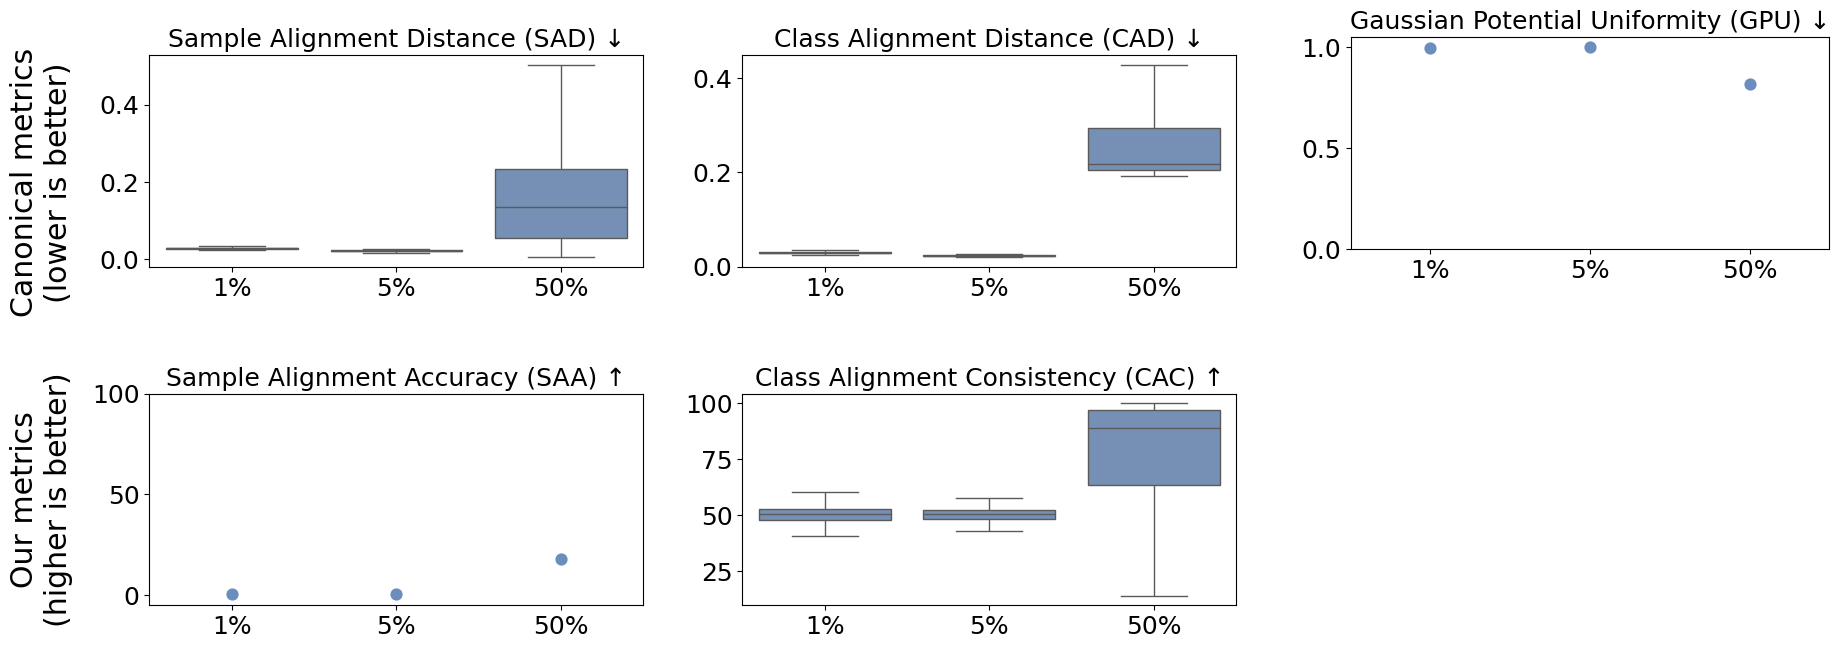

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches



def prepare_data_point(metric, has_fix2=False):

    n2 = "fix2oak_plant"
    data = [
        res[f'{class_name}_fix3_1-99'][f'{metric}_cls0'],
        res[f'{class_name}_fix3_5-95'][f'{metric}_cls0'],
        res[f'{class_name}_fix3_50-50'][f'{metric}_cls0'],
        res[f'{class_name}_fix3_1-99'][f'{metric}_cls1'],
        res[f'{class_name}_fix3_5-95'][f'{metric}_cls1'],
        res[f'{class_name}_fix3_50-50'][f'{metric}_cls1'],
        res[f'{class_name}_fix2_1-99'][f'{metric}_cls0'],
        res[f'{class_name}_fix2_5-95'][f'{metric}_cls0'],
        res[f'{class_name}_fix2_1-99'][f'{metric}_cls1'],
        res[f'{class_name}_fix2_5-95'][f'{metric}_cls1']]

    imbalances = ['1%', '5%', '50%', '1%',
                  '5%', '50%', '1%', '5%', '1%', '5%']
    class_array = np.repeat(
        ['Prototypes Cls0', 'Prototypes Cls1',
            'SupUnsup Cls0', 'SupUnsup Cls1'],
        [3, 3, 2, 2])

    # Concatenating data for DataFrame
    all_data = np.array(data)
    imbalance_array = np.array(imbalances)

    # Creating DataFrame
    df = pd.DataFrame({
        'Distance': all_data,
        'Class': class_array,
        'Imbalance': imbalance_array
    })

    return df

def box_plot(metric, title, ax, has_fix2=False, title_bottom=False, y_axis_title=""):
    my_palette = {
        "SupUnsup Cls0": "#264027",  # Color for s0
        # Same color for supunsup cls0
        "Prototypes Cls0": "#264027",
        "SupUnsup Cls1":  "#B85450",  # Color for s1
        # Same color for supunsup cls1
        "Prototypes Cls1": "#264027"
    }
    df = prepare_data(metric, has_fix2)
    sns.boxplot(y="Distance", x="Imbalance", hue="Class", data=df,
                palette=my_palette, orient='v', ax=ax, showfliers=False)#, showmeans=True)
    # ax.get_legend().remove()
    ax.set(xlabel="", ylabel="")
    if title_bottom:
        ax.set_title(title, y=-0.4, fontsize=18)
    else:
        ax.set_title(title, fontsize=18)

    categories = df['Imbalance'].unique()
    fix2_indices = [i for i, cat in enumerate(categories) if '2' in cat]


    num_classes = len(df['Class'].unique())
    total_boxes = len(ax.patches)
    boxes_per_category = total_boxes / len(categories)

    hat = ['', '', '', "", '', '',]

    for i in range(total_boxes):
        if i < len(hat):
            # Apply hatches to the correct box#
            ax.patches[i].set_hatch(hat[i])
    ax.get_legend().remove()
    ax.set(xlabel="")
    ax.set(ylabel="")

def prepare_data_single(metric, has_fix2=False):

    data = [
        (res[f'{class_name}_fix3_1-99'][f'{metric}_cls0']+
        res[f'{class_name}_fix3_1-99'][f'{metric}_cls1']) /2,


        (res[f'{class_name}_fix2_1-99'][f'{metric}_cls0']+
        res[f'{class_name}_fix2_1-99'][f'{metric}_cls1'])/2,

        (res[f'{class_name}_fix3_5-95'][f'{metric}_cls0']+
        res[f'{class_name}_fix3_5-95'][f'{metric}_cls1'])/2,

        (res[f'{class_name}_fix2_5-95'][f'{metric}_cls0']+
        res[f'{class_name}_fix2_5-95'][f'{metric}_cls1'])/2,

        (res[f'{class_name}_fix3_50-50'][f'{metric}_cls0']+
        res[f'{class_name}_fix3_50-50'][f'{metric}_cls1'])/2
    ]

    print(len(data))

    print([len(d) for d in data])
    #print(len(["Prototypes"  "SupUnsup", "Prototypes", "SupUnsup", "Prototypes"]))
    cls_ar = np.repeat(
        ["Prototypes" , "SupUnsup", "Prototypes", "SupUnsup", "Prototypes"],
        [len(d) for d in data])

    imbs = ['1%',  '1%', '5%',  '5%',  '50%']

    df = pd.DataFrame({
        'Distance': np.concatenate(data),
        'Class': cls_ar,
        'Imbalance': np.repeat(imbs, [len(d) for d in data])
    })

    return df

def box_plot_single(metric, title, ax, has_fix2=False, title_bottom=False, y_axis_title=""):

    df = prepare_data_single(metric, has_fix2)

    palette = {
    'SupUnsup': '#264027',  # Replace with actual class names and desired colors
    'Prototypes': '#B85450',
  
    # Add more classes as needed
}

    sns.boxplot(y="Distance", x="Imbalance", hue="Class", data=df,palette=palette
                , orient='v', ax=ax, showfliers=False)#, showmeans=True)
    # ax.get_legend().remove()
    ax.set(xlabel="", ylabel="")
    if title_bottom:
        ax.set_title(title, y=-0.4, fontsize=18)
    else:
        ax.set_title(title, fontsize=18)

    categories = df['Imbalance'].unique()
    fix2_indices = [i for i, cat in enumerate(categories) if '2' in cat]


    num_classes = len(df['Class'].unique())
    total_boxes = len(ax.patches)
    boxes_per_category = total_boxes / len(categories)

    hat = ['', '', '', "", '', ]

    for i in range(total_boxes):
        if i < len(hat):
            # Apply hatches to the correct box#
            ax.patches[i].set_hatch(hat[i])
    ax.get_legend().remove()
    ax.set(xlabel="")
    ax.set(ylabel="")

def prepare_data(metric, has_fix2=False):

    data = [
        res[f'{class_name}_fix3_1-99'][f'{metric}_cls0'],
        res[f'{class_name}_fix3_1-99'][f'{metric}_cls1'],


        res[f'{class_name}_fix2_1-99'][f'{metric}_cls0'],
        res[f'{class_name}_fix2_1-99'][f'{metric}_cls1'],

        res[f'{class_name}_fix3_5-95'][f'{metric}_cls0'],
        res[f'{class_name}_fix3_5-95'][f'{metric}_cls1'],

        res[f'{class_name}_fix2_5-95'][f'{metric}_cls0'],
        res[f'{class_name}_fix2_5-95'][f'{metric}_cls1'],

        res[f'{class_name}_fix3_50-50'][f'{metric}_cls0'],
        res[f'{class_name}_fix3_50-50'][f'{metric}_cls1']
    ]
    cls_ar = np.repeat(
        ["Prototypes Cls0", "Prototypes Cls1",  "SupUnsup Cls0", "SupUnsup Cls1", "Prototypes Cls0",
            "Prototypes Cls1", "SupUnsup Cls0", "SupUnsup Cls1", "Prototypes Cls0", "Prototypes Cls1",],
        [len(d) for d in data])

    imbs = ['1%', '1%', '1%', '1%', '5%', '5%', '5%', '5%', '50%', '50%']

    df = pd.DataFrame({
        'Distance': np.concatenate(data),
        'Class': cls_ar,
        'Imbalance': np.repeat(imbs, [len(d) for d in data])
    })

    return df



def box_plot_n_single(metric, title, ax, data_name, title_bottom=False, x_axis_title="", y_axis_title="", y_lim=None):

    data = []
    imbalances = []
    
    if data_name.startswith("fix2"):
        # Define imbalance levels for fix2
        imbalance_levels = ['1%', '5%']
        subsets = ['1-99', '5-95']
    else:
        # Define imbalance levels for other data_names
        imbalance_levels = ['1%', '5%', '50%']
        subsets = ['1-99', '5-95', '50-50']
    
    # Iterate over each imbalance level and merge class0 and class1 data
    for imbalance, subset in zip(imbalance_levels, subsets):
        cls0_key = f'{data_name}{subset}'
        cls1_key = f'{data_name}{subset}'
        
        # Safely retrieve data; handle missing keys gracefully
        cls0_data = res.get(f'{cls0_key}', {}).get(f'{metric}_cls0', np.array([]))
        cls1_data = res.get(f'{cls1_key}', {}).get(f'{metric}_cls1', np.array([]))
        
        # Merge Class 0 and Class 1 data
        merged_data = np.concatenate([cls0_data, cls1_data])
        data.append(merged_data)
        
        # Assign the imbalance label for each data point
        imbalances.extend([imbalance] * len(merged_data))
    
    # Concatenate all data points
    all_data = np.concatenate(data)
    
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Distance': all_data,
        'Imbalance': imbalances
    })
    
    palette = {
    '1%': '#6C8EBF',  # Replace with actual class names and desired colors
    '5%': '#6C8EBF',
    '50%': '#6C8EBF',
  
    # Add more classes as needed
}
    # Create the box plot without hue since classes are merged
    sns.boxplot(
        y="Distance",
        x="Imbalance",
        data=df,
        orient='v',
        ax=ax,
        showfliers=False,
        palette=palette  # You can choose a palette that suits your preference
    )
    
    # Set axis labels and title
    ax.set_xlabel(x_axis_title)
    ax.set_ylabel(y_axis_title)
    if title_bottom:
        ax.set_title(title, y=-0.4, fontsize=18)
    else:
        ax.set_title(title, fontsize=18)
    
    # Optional: Adjust y-axis limits if needed
    if y_lim is not None:
        ax.set_ylim(y_lim)


def point_plot_n(metric, title, ax, data_name, title_bottom=False, x_axis_title="", y_axis_title="", y_lim=None):
    if data_name.startswith("fix2"):
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
                res[f'{data_name}5-95'][f'{metric}_cls0'], 
                res[f'{data_name}1-99'][f'{metric}_cls1'], 
                res[f'{data_name}5-95'][f'{metric}_cls1']]
        imb = np.array(['1%', '5%']*(len(data)//2))
    else:
        data = [res[f'{data_name}1-99'][f'{metric}_cls0'], 
                res[f'{data_name}5-95'][f'{metric}_cls0'], 
                res[f'{data_name}50-50'][f'{metric}_cls0'],
                res[f'{data_name}1-99'][f'{metric}_cls1'], 
                res[f'{data_name}5-95'][f'{metric}_cls1'], 
                res[f'{data_name}50-50'][f'{metric}_cls1']]
        imb = np.array(['1%', '5%', '50%']*(len(data)//3))

    df = pd.DataFrame({
        'Distance': np.array(data),
        'Class': np.array(["Min.Class"]*(len(data)//2) + ["Maj.Class"]*(len(data)//2)),
        'Imbalance': imb
    })

    sns.pointplot(data=df, x="Imbalance", y="Distance", hue="Class", ax=ax, linestyles="")
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.set(xlabel="", ylabel=y_axis_title)
    ax.get_legend().remove()
    
    if title_bottom:
        ax.set_title(title, y=-0.4, fontsize=18)
    else:
        ax.set_title(title, fontsize=18)

def point_plot_n_single(metric, title, ax, data_name, title_bottom=False, x_axis_title="", y_axis_title="", y_lim=None, has_fix2=False,usedf=False):
    new_df = None
    if usedf:
        df = prepare_data_point(metric, has_fix2)
        df['SupUnsup_Mean'] = df[['SupUnsup Cls0', 'SupUnsup Cls1']].mean(axis=1)

        # Calculate the mean for Prototypes columns
        df['Prototypes_Mean'] = df[['Prototypes Cls0', 'Prototypes Cls1']].mean(axis=1)

        # Create the new DataFrame with only the mean columns
        new_df = df[['SupUnsup_Mean', 'Prototypes_Mean']].rename(
            columns={'SupUnsup_Mean': 'SupUnsup', 'Prototypes_Mean': 'Prototypes'}
        
        
)

    else:
        data = [np.vstack((res[f'{data_name}1-99'][f'{metric}_cls0'], res[f'{data_name}1-99'][f'{metric}_cls1'],)).flatten().mean(),
                np.vstack((res[f'{data_name}5-95'][f'{metric}_cls0'], res[f'{data_name}5-95'][f'{metric}_cls1'],)).flatten().mean(),
                np.vstack((res[f'{data_name}50-50'][f'{metric}_cls0'], res[f'{data_name}50-50'][f'{metric}_cls1'],)).flatten().mean()]
            

        imb = np.array(['1%', '5%', '50%'])
    df = pd.DataFrame({
        'Distance': np.array(data),
        
        'Imbalance': imb
    })
    palette = {
    'SupUnsup': '#264027',  # Replace with actual class names and desired colors
    'Prototypes': '#B85450',
  
    # Add more classes as needed
}
    if new_df is not None:
        sns.pointplot(data=new_df, x="Imbalance", y="Distance", hue="Class", ax=ax, palette=palette, markers=["x", "x", "o", "o"], ci="sd", linestyles="")
    else:
        sns.pointplot(data=df, x="Imbalance", y="Distance",  ax=ax,color="#6C8EBF", linestyles="")
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.set(xlabel="", ylabel=y_axis_title)
    #ax.get_legend().remove()
    
    if title_bottom:
        ax.set_title(title, y=-0.4, fontsize=18)
    else:
        ax.set_title(title, fontsize=18)


def point_plot(metric, title, ax, has_fix2=False, title_bottom=False, y_axis_title="", y_lim=None,palette="Set2"):
    my_palette = {
        "SupUnsup Cls0": sns.color_palette()[0],  # Color for s0
        # Same color for supunsup cls0
        "Prototypes Cls0": sns.color_palette()[0],
        "SupUnsup Cls1": "#264027",  # Color for s1
        # Same color for supunsup cls1
        "Prototypes Cls1": "#B85450"
    }
    df = prepare_data_point(metric, has_fix2)
    g1 = sns.pointplot(data=df, x="Imbalance", y="Distance", hue="Class", ax=ax, palette=my_palette, markers=["x", "x", "o", "o"], ci="sd", linestyles="")
    if y_lim is not None:
        ax.set_ylim(y_lim)

    ax.set(xlabel="", ylabel="")
    if title_bottom:
        ax.set_title(title, y=-0.4, fontsize=18)
    else:
        ax.set_title(title, fontsize=18)
    line_styles = {
        "SupUnsup Cls0": "-",
        "SupUnsup Cls1": "-",
        "Prototypes Cls0": ":",
        "Prototypes Cls1": ":"
    }

    # for h in g1.legend_.legendHandles:
    #     h.set_linestyle("")


    ax.get_legend().remove()

def point_plot_single(metric, title, ax, has_fix2=False, title_bottom=False, y_axis_title="", y_lim=None,palette="Set2"):
    my_palette = {
        "SupUnsup Cls0": sns.color_palette()[0],  # Color for s0
        # Same color for supunsup cls0
        "Prototypes Cls0": sns.color_palette()[0],
        "SupUnsup Cls1": sns.color_palette()[1],  # Color for s1
        # Same color for supunsup cls1
        "Prototypes Cls1": sns.color_palette()[1]
    }
    df = prepare_data_point(metric, has_fix2)


    df[['Type', 'Cls']] = df['Class'].str.split(' ', expand=True)

    # Display the updated DataFrame
    print("\nDataFrame after splitting 'Class' into 'Type' and 'Cls':")

    df[['Type', 'Cls']] = df['Class'].str.split(' ', expand=True)

    # Group by 'Imbalance' and 'Type' and calculate mean 'Distance'
    mean_df = df.groupby(['Imbalance', 'Type'])['Distance'].mean().reset_index()

    # Rename 'Type' to 'Class'
    mean_df.rename(columns={'Type': 'Class', 'Distance': 'Distance'}, inplace=True)

    # Optional: Ensure 'Imbalance' is ordered correctly
    # If 'Imbalance' is categorical and needs ordering, define the category order
    imbalance_order = ['1%', '5%', '50%']
    mean_df['Imbalance'] = pd.Categorical(mean_df['Imbalance'], categories=imbalance_order, ordered=True)

    g1 = sns.pointplot(data=mean_df, x="Imbalance", y="Distance", hue="Class", ax=ax, linestyles="", markers=["x", "o", "o"], ci="sd", palette = {
        "SupUnsup": "#264027",  # Color for s0,
        "Prototypes": "#B85450"
                       })
    if y_lim is not None:
        ax.set_ylim(y_lim)

    ax.set(xlabel="", ylabel="")
    if title_bottom:
        ax.set_title(title, y=-0.4, fontsize=18)
    else:
        ax.set_title(title, fontsize=18)
    line_styles = {
        "SupUnsup Cls0": "-",
        "SupUnsup Cls1": "-",
        "Prototypes Cls0": ":",
        "Prototypes Cls1": ":"
    }

    # for h in g1.legend_.legendHandles:
    #     h.set_linestyle("")


    ax.get_legend().remove()

f, axes = plt.subplots(2, 3, figsize=(21, 5.5), gridspec_kw={'hspace': 0.6})

# Plot for the unsupervised case

data_name = f'{class_name}_sup'

box_plot_n_single("sample_alignment_distance", "Sample Alignment Distance (SAD) ↓", axes[0, 0],data_name, title_bottom=False ,y_axis_title="",)
box_plot_n_single("class_alignment_consistency","Class Alignment Consistency (CAC) ↑", axes[1, 1] , data_name,y_axis_title="", )
box_plot_n_single("class_alignment_distance","Class Alignment Distance (CAD) ↓", axes[0, 1],data_name,title_bottom=False ,y_axis_title="", )

# y_lim = (0.0, 0.15)
# if model == "sup":
y_lim = (0.0, 1.05)

pos_upper = axes[0, 2].get_position()
pos_lower = axes[1, 2].get_position()

axes[0,2].axis('off')
axes[1,2].axis('off')

# Calculate the center position between the two axes
new_ax_width =  pos_upper.width
new_ax_height = pos_upper.height # Adjust the height as needed
new_ax_y =  1.11 * pos_upper.y0 
new_ax_position = [pos_upper.x0, new_ax_y, new_ax_width, 1.3*new_ax_height]

# Add the new axes to the figure
new_ax = f.add_axes(new_ax_position)

point_plot_n_single("gaussian_potential_uniformity","Gaussian Potential Uniformity (GPU) ↓", new_ax,data_name,title_bottom=False,y_axis_title="", y_lim=(0.0, 1.05))

# y_lim = (90.1, 102.0)
# if model == "sup":
y_lim = (-5.0, 100)
point_plot_n_single("sample_alignment_accuracy","Sample Alignment Accuracy (SAA) ↑", axes[1, 0],data_name,title_bottom = False, y_axis_title="", y_lim=y_lim)
#box_plot_n("uniformity_entropies","Probabilistic Entropy Uniformity (PEU) ↑", axes[1, 2],data_name, y_axis_title="")

data_name = f'{class_name}_fix_'

# box_plot_single("sample_alignment_distance", "Sample Alignment Distance (SAD) ↓",
#          axes[2, 0],data_name, title_bottom=False, y_axis_title="l2 dist",)

# box_plot_single("class_alignment_consistency", "Class Alignment Consistency (CAC) ↑",
#          axes[3, 1], y_axis_title="acc", has_fix2=True)
# box_plot_single("class_alignment_distance", "Class Alignment Distance (CAD) ↓",
#          axes[2, 1], title_bottom=False, y_axis_title="l2 dist", has_fix2=True)

# pos_upper = axes[2, 2].get_position()
# pos_lower = axes[3, 2].get_position()


# #axes[2,2].axis('off')
# axes[3,2].axis('off')



# # Calculate the center position between the two axes
# new_ax_width = pos_upper.width
# new_ax_height = pos_upper.height  # Adjust the height as needed
# new_ax_y = 0.5 * pos_upper.y0 
# new_ax_position = [pos_upper.x0, new_ax_y, new_ax_width,1.25* new_ax_height]

# # Add the new axes to the figure
# #new_ax = f.add_axes(new_ax_position)

# point_plot_single("gaussian_potential_uniformity", "Gaussian Potential Uniformity (GPU) ↓",
#            axes[2,2], title_bottom=False, y_axis_title="Gausian Uniformity", y_lim=(0.0, 0.25), has_fix2=True,)

# point_plot_single("sample_alignment_accuracy", "Sample Alignment Accuracy (SAA) ↑",
#            axes[3, 0],title_bottom=False, y_axis_title="acc", y_lim=(80.0, 105.0), has_fix2=True,)
# # box_plot("uniformity_entropies", "Probabilistic Entropy Uniformity (PEU) ↑",
# #          axes[3, 2], y_axis_title="% of max entropie", has_fix2=True)



#     #sns.despine(offset=10, trim=True)

#     #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

# ##############################################################################################################

# # Adding legend to the proposed fix case

# Annotating labels on the left side with padding
orange_patch = mpatches.Patch(color='#264027', label='Supervised Minority')
blue_patch = mpatches.Patch(color='#B85450', label='Supervised Prototypes')

grey_patch = mpatches.Patch(color="#6C8EBF", label='SupCon')
grey_patch_proto = mpatches.Patch(edgecolor="black",facecolor="#6C8EBF", label='Both Classes\n(Sup. Prototypes)', hatch='///')

orange_patch_proto = mpatches.Patch(edgecolor="black", facecolor='#264027',
                                    label='Minority Class\n(Sup. Prototypes)', hatch='///')
blue_patch_proto = mpatches.Patch(edgecolor="black", facecolor='#B85450', label='Majority Class\n(Sup. Prototypes)', hatch='///')

orange_patch_nofix = mpatches.Patch(color='#264027', label='Minority Class')
blue_patch_nofix  = mpatches.Patch(color='#B85450', label='Majority Class')

padding = 10  # Adjust the padding value as needed
axes[1, 0].annotate('Canonical metrics\n(lower is better)', xy=(-0.05, 2.0), xytext=(-60, 0),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90)
axes[1, 0].annotate('Our metrics\n(higher is better)', xy=(-0.05, 0.5), xytext=(-60, 0),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90)
# axes[3, 0].annotate('Proposed Fixes', xy=(-0.05, 1.3), xytext=(-60, 0),
#                     xycoords='axes fraction', textcoords='offset points',
#                     size='x-large', ha='center', va='center', rotation=90)

# Adding a horizontal line between the two sets of plots
#line_y = (axes[1, 1].get_position().y0 + axes[2, 1].get_position().y1) / 2 - 0.000
#f.add_artist(plt.Line2D([0.03, 0.93], [line_y, line_y], color="black", linewidth=1))
#legend = f.legend(handles=[orange_patch, blue_patch], loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

# pos = axes[1, 2].get_position()  # Get position in figure coordinates

# # Define the offset for the legend relative to the target axes
# # Adjust these values as needed
# x_offset = -0.25  # Move the legend to the right
# y_offset = -0.48  

# #orange_patch_proto, blue_patch_proto ,                            grey_patch,grey_patch_proto
# legend = f.legend(handles=[orange_patch, blue_patch, ], loc='center left', ncol=1, borderaxespad=0.1,  prop={'size': 20,},
#                              frameon=False, bbox_to_anchor=(pos.x1 + x_offset, pos.y0 + 0.5 * pos.height + y_offset))
# pos = axes[1, 2].get_position()  # Get position in figure coordinates

# # Define the offset for the legend relative to the target axes
# # Adjust these values as needed
# x_offset = -0.25  # Move the legend to the right
# y_offset = 0.1  
# # grey_patch
# # legend = f.legend(handles=[grey_patch], loc='center left',
# #                     ncol=1, borderaxespad=0.1, prop={'size': 20,},
# #                     frameon=False, bbox_to_anchor=(pos.x1 + x_offset, pos.y0 + 0.5 * pos.height + y_offset))

# #plt.tight_layout(pad=5.0, h_pad=2000.0, w_pad=100.5)
# #f.savefig(f'/vol/aimspace/users/mildenbd/Projects/baselines_eccv/new_figs/{class_name}/all_figures_{model}.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

#plt.tight_layout(pad=3.0, h_pad=1.0, w_pad=0.5, )


#legend = f.legend(handles=[orange_patch, blue_patch, orange_patch_proto, blue_patch_proto],
                  #loc='lower center', ncol=4, borderaxespad=0.1, frameon=False, bbox_to_anchor=(0.5, 0.01))
plt.subplots_adjust(top=1, bottom=0.0, hspace=2.0, wspace=0.2, left=0.1 ,right=0.9)
plt.rcParams.update({'font.size': 18})

# When saving the figure, include the legend in 'bbox_extra_artists' to make sure it's accounted for in the tight layout calculation
f.savefig(f'new_figs/fixsup-all_figures_{class_name}.pdf', bbox_inches='tight', pad_inches=0.1)# bbox_extra_artists=(legend,), bbox_inches='tight')
print(f'new_figs/fixsup-all_figures.pdf')
plt.show()

In [ ]:
print(res.keys())

In [ ]:
inat_scores_df = pd.read_csv("/vol/aimspace/users/hagp/cvpr_25/inat_scores.csv")
inat_scores_df.set_index("Method", inplace=True) 
plants_scores_df = inat_scores_df[['plants_50', 'plants_5', 'plants_1']]
plants_scores_df
# plants_5_scores_df = plants_scores_df[["plants_5"]]

In [ ]:
infarction_scores_df = pd.read_csv("/vol/aimspace/users/hagp/cvpr_25/infarction_scores.csv")
infarction_scores_df.set_index("Method", inplace=True) 
infarction_scores_df

In [ ]:
import pickle
import numpy as np


res_plants_5 = pickle.load(open("/vol/aimspace/users/hagp/cvpr_25/all_baselines_plants_all_splits.pkl", "rb"))
# res_fig_4 = pickle.load(open(f'embeddings/embeddings/{class_name}/results_5_last_val.pkl', 'rb'))
# res_infarction = pickle.load(open(f'all_baselines_medical_5.pkl', 'rb'))
res = res_plants_5
res_2 = {}
for r in res_plants_5.keys():
    if "plant" in r:
        res_2[r] = res_plants_5[r]
res = res_2

In [ ]:
res.keys()

In [ ]:
summary_res = {}
for k in res.keys():
    summary_res[k] = {}
    summary_res[k]["SAD"] = np.concatenate([res[k]["sample_alignment_distance_cls0"], res[k]["sample_alignment_distance_cls1"]]).mean()
    summary_res[k]["SAA"] = (res[k]["sample_alignment_accuracy_cls0"] + res[k]["sample_alignment_accuracy_cls1"])/2

    summary_res[k]["CAD"] = np.concatenate([res[k]["class_alignment_distance_cls0"], res[k]["class_alignment_distance_cls1"]]).mean()
    summary_res[k]["CAC"] = np.concatenate([res[k]["class_alignment_consistency_cls0"], res[k]["class_alignment_consistency_cls1"]]).mean()

    summary_res[k]["GPU"] = (res[k]["gaussian_potential_uniformity_cls0"] + res[k]["gaussian_potential_uniformity_cls1"])/2

In [ ]:
metrics_df = pd.DataFrame(summary_res).T

models = ["SupCon", "KCL", "TSC", "SBC", "BCL", "Sup Minority", "Sup Prototypes"]
indices = []
for m in models:
    for split in ["1", "5", "50"]:
        if m == "Sup Minority" and split == "50":
            continue
        indices.append(f"plants_{split}-{m}")
# indices_ordered = ['plants_1-xent',
#  'plants_5-xent',
#  'plants_50-xent',
#  'plants_1-SupCon',
#  'plants_50-SupCon',
#  'plants_5-SupCon',
#  'plants_1-Sup Minority',
#  'plants_5-Sup Minority',
#  'plants_1-Sup Prototypes',
#  'plants_5-Sup Prototypes',
#  'plants_50-Sup Prototypes']

# indices_ordered = [
#     "plants_5-SupCon",
#     "plants_5-KCL",
#     "plants_5-TSC",
#     "plants_5-SBC",
#     "plants_5-BCL",
#     "plants_5-Sup Minority",
#     "plants_5-Sup Prototypes",
# ]

# indices_ordered = [
#     "infarction_5-SupCon",
#     "infarction_5-KCL",
#     "infarction_5-TSC",
#     "infarction_5-SBC",
#     "infarction_5-BCL",
#     "infarction_5-Sup Minority",
#     "infarction_5-Sup Prototypes",
# ]


metrics_df.index = indices

In [ ]:
metrics_df

In [ ]:
scores_df = infarction_scores_df
target = "infarction"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's extract the relevant data
# methods = ["SupCon", "Sup Minority", "Sup Prototypes"]
methods = ["SupCon", "KCL", "TSC", "SBC", "BCL", "Sup Minority", "Sup Prototypes"]
plot_data = []

for method in methods:
    # Get scores for each split
    # for split in ["1", "5", "50"]:
    for split in ["5"]:
        # Skip Sup Minority for split 50 as it doesn't exist
        if method == "Sup Minority" and split == "50":
            continue
            
        # Get the CAC value from metrics df
        cac_value = metrics_df.loc[f"{target}_{split}-{method}", "CAC"]
        
        # Get the corresponding score from {target}_scores_df
        score = scores_df.loc[method, f"Infarction"]
        
        plot_data.append({
            'Method': method,
            'Split': split,
            'CAC': cac_value,
            'Score': score
        })

# Create a DataFrame for plotting
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='CAC', y='Score', hue='Method', style='Split', s=100)

# Customize the plot
plt.title('Model Performance: CAC vs Score')
plt.xlabel('CAC (Class Activation Consistency)')
plt.ylabel('Score')

# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's extract the relevant data
methods = models
plot_data = []

for method in methods:
    for split in ["1", "5", "50"]:
        # Skip Sup Minority for split 50 as it doesn't exist
        if method == "Sup Minority" and split == "50":
            continue
            
        # Get the CAC value from metrics df
        cac_value = metrics_df.loc[f"plants_{split}-{method}", "CAC"]
        
        # Get the corresponding score from plants_scores_df
        score = plants_scores_df.loc[method, f"plants_{split}"]
        
        plot_data.append({
            'Method': method,
            'CAC': cac_value,
            'Score': score
        })

# Create a DataFrame for plotting
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='CAC', y='Score', hue='Method', s=100)

# Customize the plot
plt.title('Model Performance: CAC vs Score')
plt.xlabel('CAC (Class Activation Consistency)')
plt.ylabel('Score')

plt.gca().invert_yaxis()  # This line is removed to make scores increase upward

# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup the subplot grid
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3)

# First, let's extract the relevant data
methods = models
plot_data = []

# Metrics to plot
top_metrics = ['SAD', 'CAD', 'GPU']
bottom_metrics = ['SAA', 'CAC']

for method in methods:
   for split in ["1", "5", "50"]:
       # Skip Sup Minority for split 50 as it doesn't exist
       if method == "Sup Minority" and split == "50":
           continue
           
       # Get all metric values
       metric_values = metrics_df.loc[f"plants_{split}-{method}"]
       
       # Get the corresponding score from plants_scores_df
       score = plants_scores_df.loc[method, f"plants_{split}"]
       
       plot_data.append({
           'Method': method,
           'SAD': metric_values['SAD'],
           'SAA': metric_values['SAA'],
           'CAD': metric_values['CAD'],
           'CAC': metric_values['CAC'],
           'GPU': metric_values['GPU'],
           'Score': score,
           'Split': split
       })

# Create a DataFrame for plotting
plot_df = pd.DataFrame(plot_data)

# Create top row of subplots
for idx, metric in enumerate(top_metrics):
   ax = fig.add_subplot(gs[0, idx])
   sns.scatterplot(data=plot_df, x=metric, y='Score', hue='Method', style='Split', s=100, ax=ax)
   
   # Customize each subplot
   ax.set_xlabel(metric)
   ax.set_ylabel('Accuracy')
   ax.grid(True, linestyle='--', alpha=0.7)
   
   # Remove legend from these plots
   ax.get_legend().remove()
   ax.invert_yaxis()  # This line is removed to make scores increase upward

# Create bottom row of subplots (except last position)
for idx, metric in enumerate(bottom_metrics):
   ax = fig.add_subplot(gs[1, idx])
   sns.scatterplot(data=plot_df, x=metric, y='Score', hue='Method', style='Split', s=100, ax=ax)
   
   # Customize each subplot
   ax.set_title(f'{metric} vs Score')
   ax.set_xlabel(metric)
   ax.set_ylabel('Score')
   ax.grid(True, linestyle='--', alpha=0.7)
   
   # Remove legend from these plots
   ax.get_legend().remove()
   ax.invert_yaxis()  # This line is removed to make scores increase upward


# Create legend in the empty space
legend_ax = fig.add_subplot(gs[1, 2])
legend_ax.axis('off')

# Get the handles and labels from the last plot
handles, labels = ax.get_legend_handles_labels()

# Place the legend in the empty subplot
legend_ax.legend(handles, labels, loc='center', 
               bbox_to_anchor=(0.5, 0.5), fontsize='large')

# Adjust layout
plt.gca().invert_yaxis()  # This line is removed to make scores increase upward
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Setup the subplot grid
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3)

# First, let's extract the relevant data
methods = models
plot_data = []

# Metrics to plot
top_metrics = ['SAD', 'CAD', 'GPU']
bottom_metrics = ['SAA', 'CAC']

for method in methods:
    for split in ["1", "5", "50"]:
        # Skip Sup Minority for split 50 as it doesn't exist
        if method == "Sup Minority" and split == "50":
            continue
            
        # Get all metric values
        metric_values = metrics_df.loc[f"plants_{split}-{method}"]
        
        # Get the corresponding score from plants_scores_df
        score = plants_scores_df.loc[method, f"plants_{split}"]
        
        plot_data.append({
            'Method': method,
            'SAD': metric_values['SAD'],
            'SAA': metric_values['SAA'],
            'CAD': metric_values['CAD'],
            'CAC': metric_values['CAC'],
            'GPU': metric_values['GPU'],
            'Score': score,
            'Split': split
        })

# Create a DataFrame for plotting
plot_df = pd.DataFrame(plot_data)

# Function to calculate and add correlation coefficient
def add_correlation(ax, data, x_col, y_col):
    r, p = stats.pearsonr(data[x_col], data[y_col])
    ax.text(0.95, 0.05, f'R2 = {r*r:.2f}', 
            transform=ax.transAxes, 
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Create top row of subplots
for idx, metric in enumerate(top_metrics):
    ax = fig.add_subplot(gs[0, idx])
    sns.scatterplot(data=plot_df, x=metric, y='Score', hue='Method', style='Split', s=100, ax=ax)
    
    # Add correlation coefficient
    add_correlation(ax, plot_df, metric, 'Score')
    
    # Customize each subplot
    ax.set_xlabel(metric)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(100, 40)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Remove legend from these plots
    ax.get_legend().remove()
    ax.invert_yaxis()

# Create bottom row of subplots (except last position)
for idx, metric in enumerate(bottom_metrics):
    ax = fig.add_subplot(gs[1, idx])
    sns.scatterplot(data=plot_df, x=metric, y='Score', hue='Method', style='Split', s=100, ax=ax)
    
    # Add correlation coefficient
    add_correlation(ax, plot_df, metric, 'Score')
    
    # Customize each subplot
    ax.set_xlabel(metric)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(100, 40)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Remove legend from these plots
    ax.get_legend().remove()
    ax.invert_yaxis()

# Create legend in the empty space
legend_ax = fig.add_subplot(gs[1, 2])
legend_ax.axis('off')

# Get the handles and labels from the last plot
handles, labels = ax.get_legend_handles_labels()

# Split handles and labels into Method and Split
n_methods = len(methods)
method_handles = handles[1:n_methods]
method_labels = labels[1:n_methods]
split_handles = handles[-3:]
split_labels = labels[-3:]

# Place the legends side by side
#legend_ax.legend(method_handles, method_labels, loc='center left', 
#                bbox_to_anchor=(0.2, 0.5), fontsize='large', title='Method')
# legend_ax.add_artist(legend_ax.legend(split_handles, split_labels, loc='center right', 
#                bbox_to_anchor=(0.8, 0.5), fontsize='large', title='Split'))


# Adjust layout
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

fig.savefig(f'new_figs/correlation_2.svg', bbox_inches='tight', pad_inches=0.1)# bbox_extra_artists=(legend,), bbox_inches='tight')

In [ ]:
method_labels